In [1]:
%matplotlib inline

import setGPU
import os, h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
import glob
from scipy.stats import skew
from scipy.stats import kurtosis

setGPU: Setting GPU to: 0


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def loadModel(name, weights=False):
    '''
    Adapted from Kaustuv Datta and Jayesh Mahapatra's CaloImageMacros.
    Loads models from json file.
    :parameter name: name of the json file.
    :type name: str
    :parameter weights: whether or not to load the weights.
    :type weights: bool
    :return: loaded model.
    '''
    from keras.models import model_from_json
    json_file = open('%s' % name, 'r')
    loaded = json_file.read()
    json_file.close()

    model = model_from_json(loaded)

    # load weights into new model
    if weights == True:
        model.load_weights('%s.h5' % name)
    # print(model.summary())

    #print("Loaded model from disk")
    return model

In [3]:
latent_space=100
batch_size=128

noise = np.random.normal(0, 1, (batch_size, latent_space))

In [26]:
def getMetric(all_g_weight, gen_model):
    g = loadModel(gen_model)

    means = []
    stds = []
    epochs = []
    variances = []
    skews = []
    kurtoses = []

    for w in glob.glob(all_g_weight):
        epoch = w.split('/')[-1].split('_')[3]

        g.load_weights(w)
        generated_images = g.predict(noise)
        #generated_images = generated_images.squeeze()

        means.append(np.mean(generated_images))
        stds.append(np.std(generated_images))
        epochs.append(int(epoch))
        variances.append(np.var(generated_images))
        skews.append(skew(generated_images, axis=None))
        kurtoses.append(kurtosis(generated_images, axis=None))
    
    return means, stds, epochs, variances, skews, kurtoses

In [11]:
all_g_weight2 = '/nfshome/vitoriabp/hgcal_wgan/trial26/weights/generator_weights_epoch_*.h5'
gen_model2 = '/nfshome/vitoriabp/hgcal_wgan/trial26/weights/generator_model_change_discriminator.json'

In [6]:
all_g_weight1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_weights_epoch_*.h5'
gen_model1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_model_bs_128_lr_0.00005_latent_100_ncritic_5_clip_0.01_shuffle.json'

In [27]:
means1, stds1, epochs1, vars1, skews1, kurtoses1 = getMetric(all_g_weight1, gen_model1)

In [28]:
means2, stds2, epochs2, vars2, skews2, kurtoses2 = getMetric(all_g_weight2, gen_model2)

In [13]:
def sortMeans(epochs, means):
    epoch_mean = np.array([np.asarray(epochs), np.asarray(means)])
    epoch_mean_sorted = (epoch_mean.T)[np.argsort(epoch_mean[0])]
    return epoch_mean_sorted

In [14]:
epoch_mean_sorted1 = sortMeans(epochs1, means1)

In [15]:
epoch_mean_sorted2 = sortMeans(epochs2, means2)

In [16]:
def plotMean(epoch_mean_sorted):
    plt.scatter(epoch_mean_sorted[:,0], epoch_mean_sorted[:,1], alpha=0.6, color='blue')
    plt.title("Mean energy generated", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("$\mu$ (GeV)", size=16)
    #plt.xlim(-50, 1000)
    ## ACTIVATE YLIM
    #plt.ylim(0, 0.05)
    #plt.savefig("means.png")
    plt.errorbar(epoch_mean_sorted[:,0], epoch_mean_sorted[:,1], yerr=np.std(epoch_mean_sorted[:,1])/np.sqrt(len(epoch_mean_sorted[:,1])), color='orange', alpha = 0.3, fmt='o')

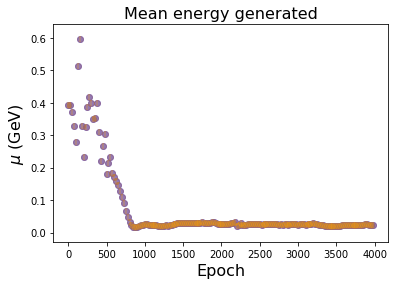

In [17]:
plotMean(epoch_mean_sorted1)

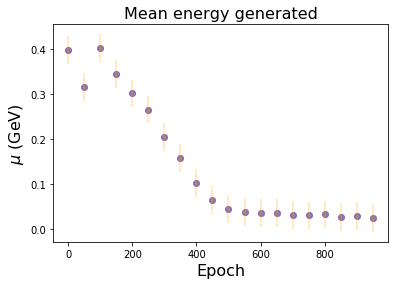

In [18]:
plotMean(epoch_mean_sorted2)

In [19]:
def plotMeans(epoch_mean_sorted1, epoch_mean_sorted2):
    plt.scatter(epoch_mean_sorted1[:,0], epoch_mean_sorted1[:,1], label="first")
    plt.scatter(epoch_mean_sorted2[:,0], epoch_mean_sorted2[:,1], label="second")
    plt.title("Mean energy generated", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("$\mu$ (GeV)", size=16)
    plt.xlim(-50, 1000)
    #plt.ylim(0, 1.5)
    plt.legend()
    #plt.savefig("means.png")
    #plt.errorbar(epoch_mean_sorted[:,0], epoch_mean_sorted[:,1], yerr=np.std(epoch_mean_sorted[:,1])/np.sqrt(len(epoch_mean_sorted[:,1])), color='grey', alpha = 0.5, fmt='o')

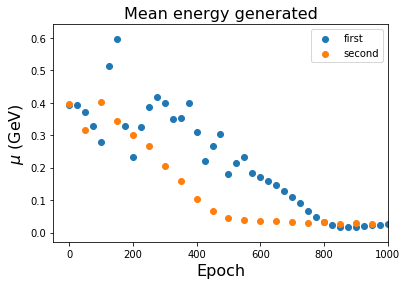

In [20]:
plotMeans(epoch_mean_sorted1, epoch_mean_sorted2)

In [19]:
## No need to execute this again
#f = h5py.File('/bigdata/shared/HGCAL_data/new/all_noPU.h5', 'r')
#X = np.asarray(f['X'])
#X = X.squeeze()

In [20]:
## Should aim for:
#np.mean(X) = 0.02

In [21]:
def plotStd(epochs, stds):
    plt.scatter(epochs, stds, alpha=0.5, color='green')
    plt.title("Standard deviation of energy generated", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("$\sigma$ (GeV)", size=16)
    #plt.xlim(-50, 1000)
    plt.ylim(0, 0.5)
    #plt.savefig("stds.png")

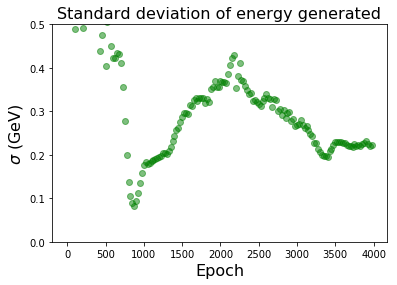

In [22]:
plotStd(epochs1, stds1)

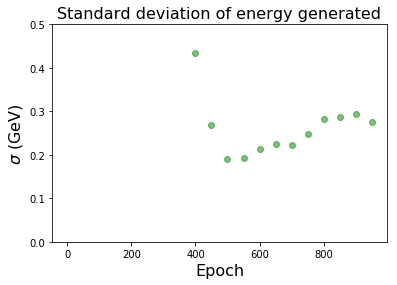

In [23]:
plotStd(epochs2, stds2)

In [24]:
def plotStds(epochs1, stds1, epochs2, stds2):
    plt.scatter(epochs1, stds1, label="first")
    plt.scatter(epochs2, stds2, label="second")
    plt.title("Standard deviation of energy generated", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("$\sigma$ (GeV)", size=16)
    plt.xlim(-50, 1000)
    #plt.ylim(0, 1)
    plt.legend()
    #plt.savefig("stds.png")

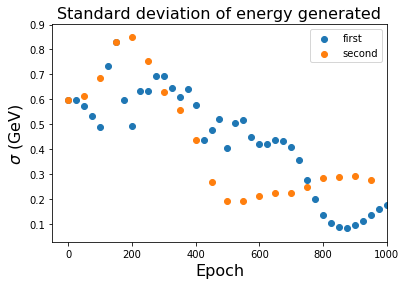

In [25]:
plotStds(epochs1, stds1, epochs2, stds2)

In [42]:
## Aim for:
#np.std(X) = 0.36

In [29]:
def plotVar(epochs, variances):
    plt.scatter(epochs, variances, alpha=0.5, color='green')
    plt.title("Variance of sample generated per epoch", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("Var", size=16)
    #plt.xlim(-50, 1000)
    #plt.ylim(0, 0.5)
    #plt.savefig("stds.png")

In [ ]:
# Aim for variance 0.12619433

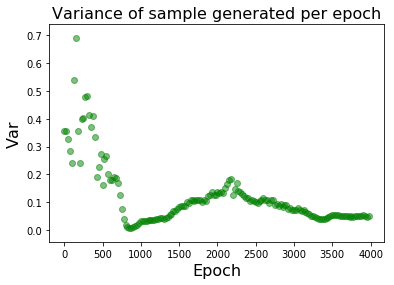

In [30]:
plotVar(epochs1, vars1)

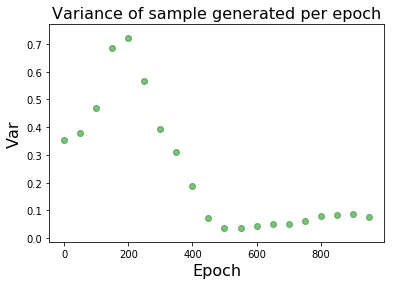

In [31]:
plotVar(epochs2, vars2)

In [32]:
def plotSkew(epochs, skews):
    plt.scatter(epochs, skews, alpha=0.5, color='green')
    plt.title("Third moment of sample generated per epoch", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("Skew", size=16)
    #plt.xlim(-50, 1000)
    #plt.ylim(0, 0.5)
    #plt.savefig("stds.png")

In [ ]:
# Skew should be 34.635719299316406

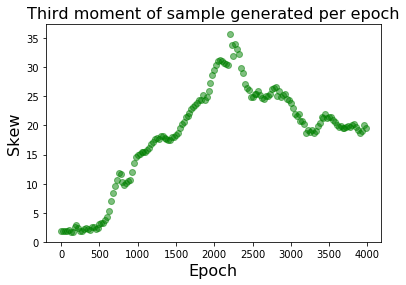

In [33]:
plotSkew(epochs1, skews1)

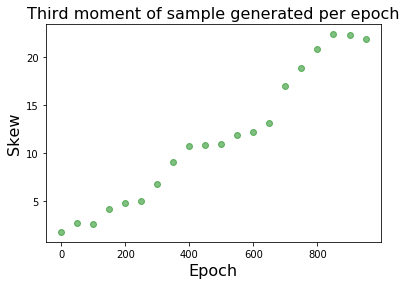

In [34]:
plotSkew(epochs2, skews2)

In [35]:
def plotKurtoses(epochs, kurtoses):
    plt.scatter(epochs, kurtoses, alpha=0.5, color='green')
    plt.title("Fourth moment of sample generated per epoch", size=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("Kurtosis", size=16)
    #plt.xlim(-50, 1000)
    #plt.ylim(0, 0.5)
    #plt.savefig("stds.png")

In [ ]:
# Kurtosis should be 1764.2194336137854

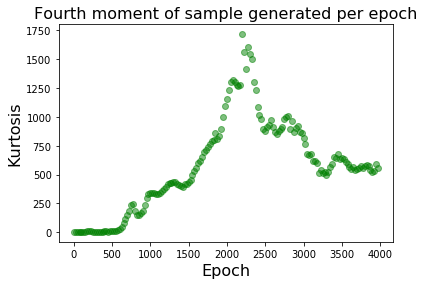

In [36]:
plotKurtoses(epochs1, kurtoses1)

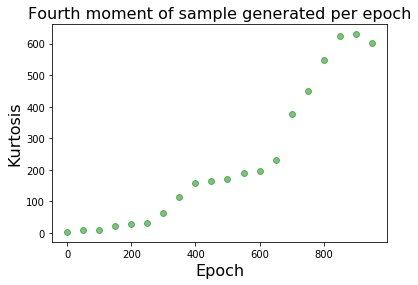

In [37]:
plotKurtoses(epochs2, kurtoses2)

# ------------ STOP EXECUTING HERE ------------------

In [68]:
f = h5py.File('/bigdata/shared/HGCAL_data/new/all_noPU.h5', 'r')
X = np.asarray(f['X'])
X = X.squeeze()

In [69]:
X.shape

(195386, 16, 16, 55)

In [72]:
np.mean(X)

0.02276984

In [71]:
np.var(X)

0.12619433

In [73]:
np.std(X)

0.3552384

In [74]:
skew(X, axis=None)

34.635719299316406

In [75]:
kurtosis(X, axis=None)

1764.2194336137854